In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/animal-research-dirty-dataset/surveys.csv


In [2]:
df=pd.read_csv("/kaggle/input/animal-research-dirty-dataset/surveys.csv")
df

,record_id,month,day,year,plot_id,species_id,sex,hindfoot_length,weight
0,1,7,16,1977,2,NL,M,32.0,NaN
1,2,7,16,1977,3,NL,M,33.0,NaN
2,3,7,16,1977,2,DM,F,37.0,NaN
3,4,7,16,1977,7,DM,M,36.0,NaN
4,5,7,16,1977,3,DM,M,35.0,NaN
...,...,...,...,...,...,...,...,...,...
35544,35545,12,31,2002,15,AH,NaN,NaN,NaN
35545,35546,12,31,2002,15,AH,NaN,NaN,NaN
35546,35547,12,31,2002,10,RM,F,15.0,14.0
35547,35548,12,31,2002,7,DO,M,36.0,51.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35549 entries, 0 to 35548
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   record_id        35549 non-null  int64  
 1   month            35549 non-null  int64  
 2   day              35549 non-null  int64  
 3   year             35549 non-null  int64  
 4   plot_id          35549 non-null  int64  
 5   species_id       34786 non-null  object 
 6   sex              33038 non-null  object 
 7   hindfoot_length  31438 non-null  float64
 8   weight           32283 non-null  float64
dtypes: float64(2), int64(5), object(2)
memory usage: 2.4+ MB


In [4]:
df.isnull().sum()

record_id             0
month                 0
day                   0
year                  0
plot_id               0
species_id          763
sex                2511
hindfoot_length    4111
weight             3266
dtype: int64

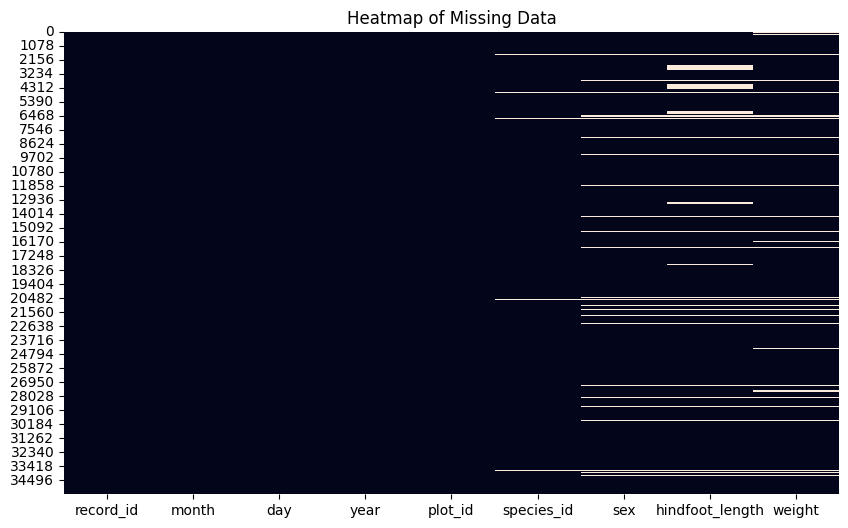

In [5]:
# we'll try to analyse more about how the missing values are distributed in order to take the best approach to handle them
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(),cbar=False )
plt.title('Heatmap of Missing Data')
plt.show()

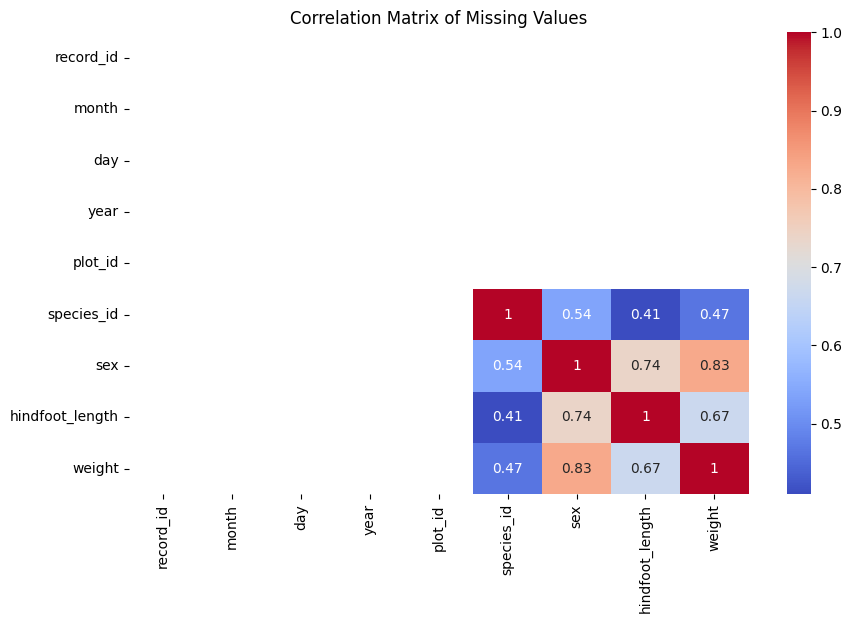

In [6]:
# now we'll plot a correlation matrix b/w the missing data to analyse further
import pandas as pd
missing_corr = df.isnull().corr()

plt.figure(figsize=(10, 6))
sns.heatmap(missing_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Missing Values')
plt.show()

In [7]:
# since missing values here is just 2% of the dataset i'll choose to drop the rows
df.dropna(subset=['species_id'],inplace=True)
df.isnull().sum()

record_id             0
month                 0
day                   0
year                  0
plot_id               0
species_id            0
sex                1748
hindfoot_length    3348
weight             2503
dtype: int64

In [8]:
# as we saw the correlation between hindfoot_length/weight and sex was considerable(0.74/0.83) that means we can replace these with their means in each sex category
df['sex'] = df['sex'].fillna(df['sex'].mode()[0])
mean_values = df.groupby('sex')[['hindfoot_length', 'weight']].mean()

df['hindfoot_length'] = df['hindfoot_length'].fillna(df.groupby('sex')['hindfoot_length'].transform('mean'))
df['weight'] = df['weight'].fillna(df.groupby('sex')['weight'].transform('mean'))


In [9]:
df.isnull().sum()

record_id          0
month              0
day                0
year               0
plot_id            0
species_id         0
sex                0
hindfoot_length    0
weight             0
dtype: int64

In [10]:
duplicates = df[df.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [record_id, month, day, year, plot_id, species_id, sex, hindfoot_length, weight]
Index: []


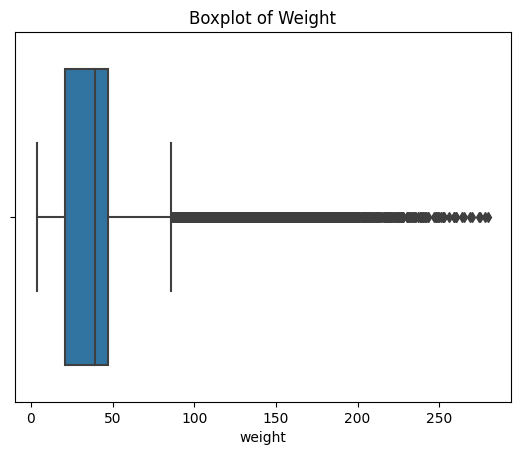

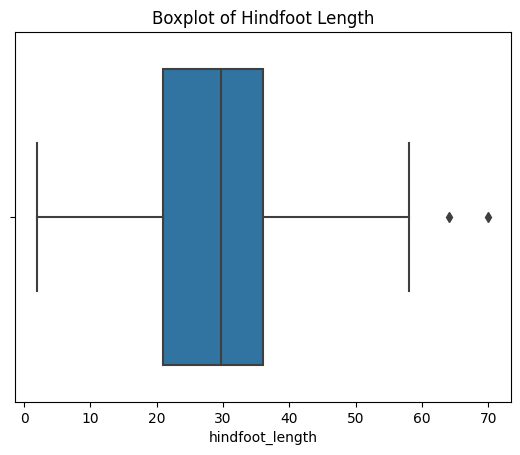

In [11]:
# now we will analyse the outliers 
# first we'll analyse them using some visualisation techiniques
sns.boxplot(x=df['weight'])
plt.title('Boxplot of Weight')
plt.show()

sns.boxplot(x=df['hindfoot_length'])
plt.title('Boxplot of Hindfoot Length')
plt.show()

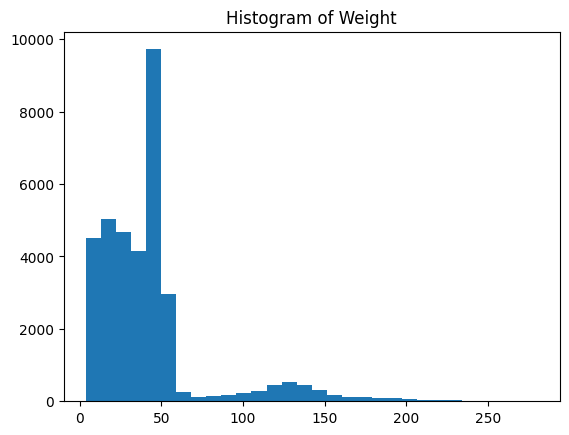

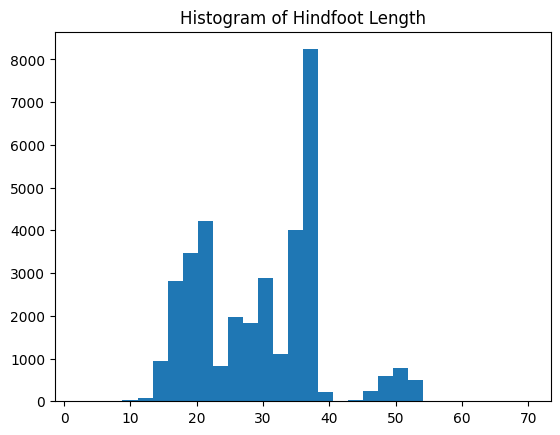

In [12]:
plt.hist(df['weight'], bins=30)
plt.title('Histogram of Weight')
plt.show()

plt.hist(df['hindfoot_length'], bins=30)
plt.title('Histogram of Hindfoot Length')
plt.show()

In [13]:
from scipy.stats import zscore
# now we will numerically analyse the outliers using z-score method
df['zscore_weight'] = zscore(df['weight'].dropna()) 
df['zscore_hindfoot'] = zscore(df['hindfoot_length'].dropna())

outliers_weight = df[(df['zscore_weight'] > 3) | (df['zscore_weight'] < -3)]
outliers_hindfoot = df[(df['zscore_hindfoot'] > 3) | (df['zscore_hindfoot'] < -3)]

print("Outliers in weight:", outliers_weight)
print("Outliers in hindfoot_length:", outliers_hindfoot)

Outliers in weight:        record_id  month  day  year  plot_id species_id sex  hindfoot_length  \
482          483     12   11  1977        8         DS   M        49.000000   
547          548      1    9  1978        8         DS   M        53.000000   
584          585      2   18  1978        2         DS   M        53.000000   
587          588      2   18  1978        2         NL   M        29.694088   
628          629      2   19  1978       14         NL   M        29.694088   
...          ...    ...  ...   ...      ...        ...  ..              ...   
35248      35249     12    7  2002       12         NL   F        33.000000   
35283      35284     12    7  2002       24         NL   M        35.000000   
35414      35415     12   29  2002       12         NL   F        33.000000   
35434      35435     12   29  2002       18         NL   F        31.000000   
35478      35479     12   29  2002       24         NL   M        32.000000   

       weight  zscore_weight  z

Skewness of weight (with outliers): 2.4177486677908786
Skewness of hindfoot_length (with outliers): 0.3273738930640154


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


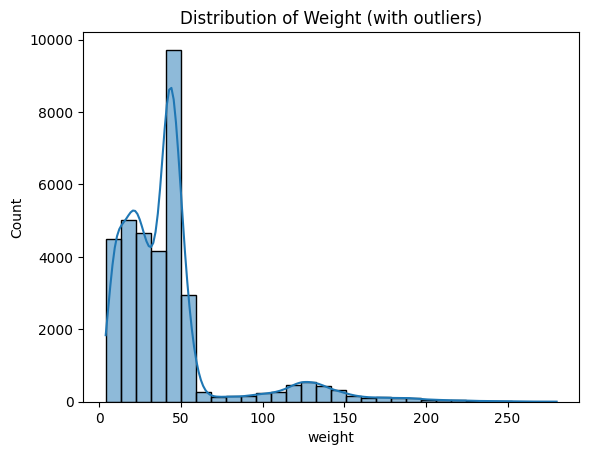

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


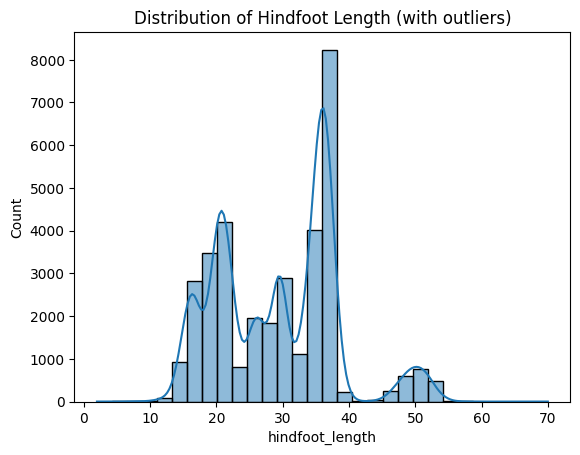

In [14]:
from scipy.stats import skew
# here we will analyse the skewness of the dataset with outliers
print("Skewness of weight (with outliers):", skew(df['weight'].dropna()))
print("Skewness of hindfoot_length (with outliers):", skew(df['hindfoot_length'].dropna()))

sns.histplot(df['weight'].dropna(), kde=True, bins=30)
plt.title("Distribution of Weight (with outliers)")
plt.show()

sns.histplot(df['hindfoot_length'].dropna(), kde=True, bins=30)
plt.title("Distribution of Hindfoot Length (with outliers)")
plt.show()

In [15]:
# here i tried to see if removing the outliers is causing any effect on the skewness of the data and i found it isnt causing much effect
# # Remove outliers based on Z-scores for weight and hindfoot_length (if Z > 3 or Z < -3)
# df_no_outliers = df[(df['zscore_weight'] < 3) & (df['zscore_weight'] > -3)]
# df_no_outliers = df_no_outliers[(df_no_outliers['zscore_hindfoot'] < 3) & (df_no_outliers['zscore_hindfoot'] > -3)]

# print("Skewness of weight (without outliers):", skew(df_no_outliers['weight'].dropna()))
# print("Skewness of hindfoot_length (without outliers):", skew(df_no_outliers['hindfoot_length'].dropna()))

# sns.histplot(df_no_outliers['weight'].dropna(), kde=True, bins=30)
# plt.title("Distribution of Weight (without outliers)")
# plt.show()

# sns.histplot(df_no_outliers['hindfoot_length'].dropna(), kde=True, bins=30)
# plt.title("Distribution of Hindfoot Length (without outliers)")
# plt.show()

Skewness of weight (log transformed): -0.0514416811078443


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


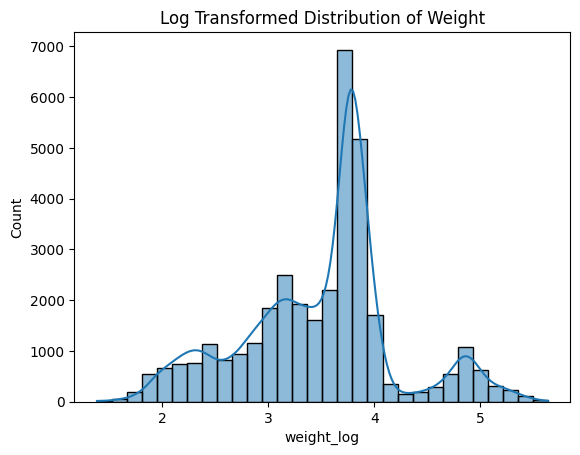

In [16]:
# so now i will log transform the weight column in order to normalise the data 
df['weight_log'] = np.log(df['weight'].replace(0, np.nan))
print("Skewness of weight (log transformed):", skew(df['weight_log'].dropna()))
sns.histplot(df['weight_log'].dropna(), kde=True, bins=30)
plt.title("Log Transformed Distribution of Weight")
plt.show()


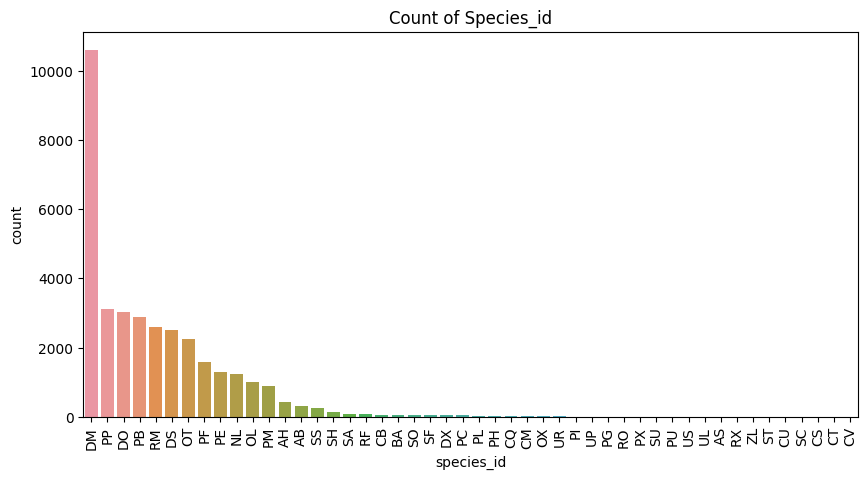

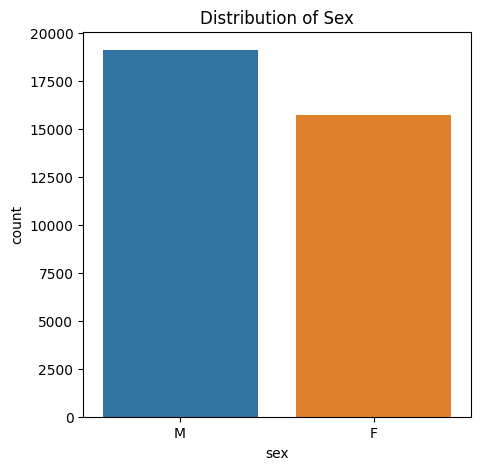

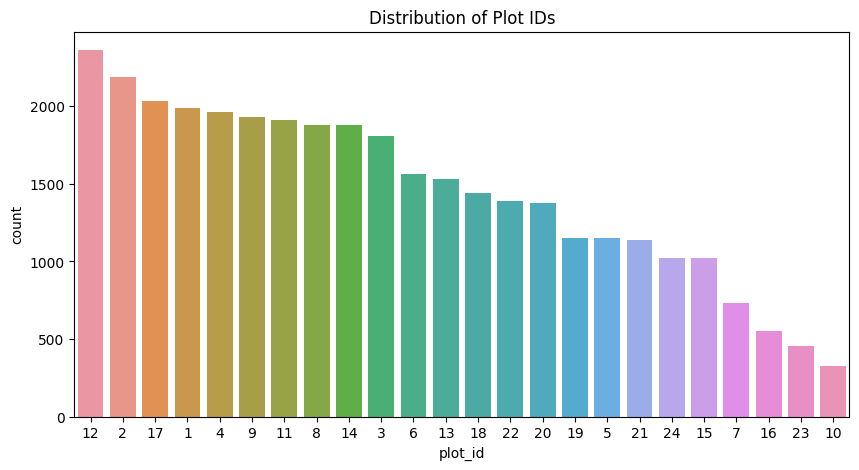

In [17]:
# as we have cleaned and transformed our data we can do some analysis on it although we have covered some analysis previously
# here we will plot the categorical columns according to their counts
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='species_id', order=df['species_id'].value_counts().index)
plt.title('Count of Species_id')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(5, 5))
sns.countplot(data=df, x='sex')
plt.title('Distribution of Sex')
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='plot_id', order=df['plot_id'].value_counts().index)
plt.title('Distribution of Plot IDs')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


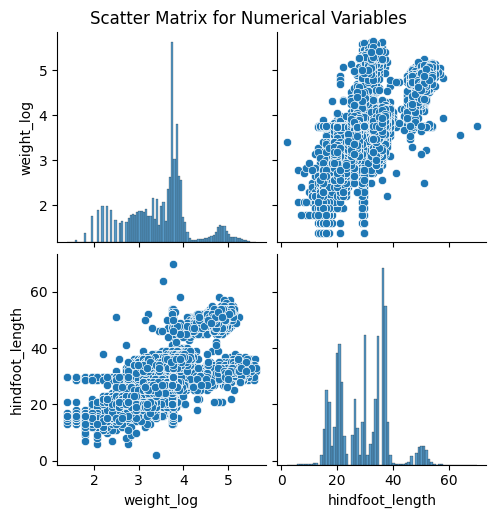

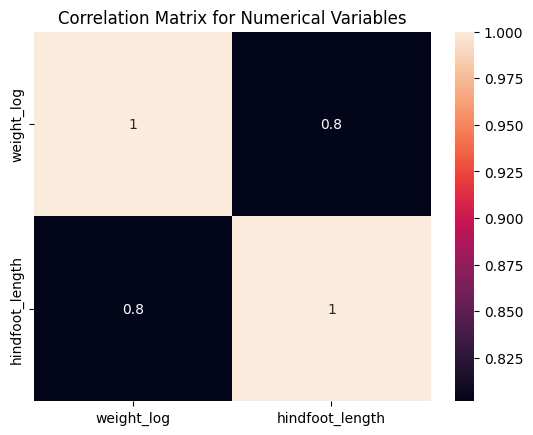

Correlation Matrix:                   weight_log  hindfoot_length
weight_log         1.000000         0.801747
hindfoot_length    0.801747         1.000000


In [18]:
import numpy as np
# now we will conduct an analysis between numerical variables , their correlation etc

sns.pairplot(df[['weight_log', 'hindfoot_length']])
plt.suptitle('Scatter Matrix for Numerical Variables', y=1.02)
plt.show()

corr_matrix = df[['weight_log', 'hindfoot_length']].corr()

sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix for Numerical Variables')
plt.show()

print("Correlation Matrix: ", corr_matrix)

In [19]:
import scipy.stats as stats
# now we will analyse the categorical variables

contingency_table = pd.crosstab(df['sex'], df['species_id'])

chi2_stat, p_val, dof, ex = stats.chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-value: {p_val}")
print(f"Degrees of Freedom: {dof}")

if p_val < 0.05:
    print("There is a significant association between sex and species.")
else:
    print("There is no significant association between sex and species.")

Chi-Square Statistic: 1413.729421158566
P-value: 2.554941722121064e-265
Degrees of Freedom: 47
There is a significant association between sex and species.


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


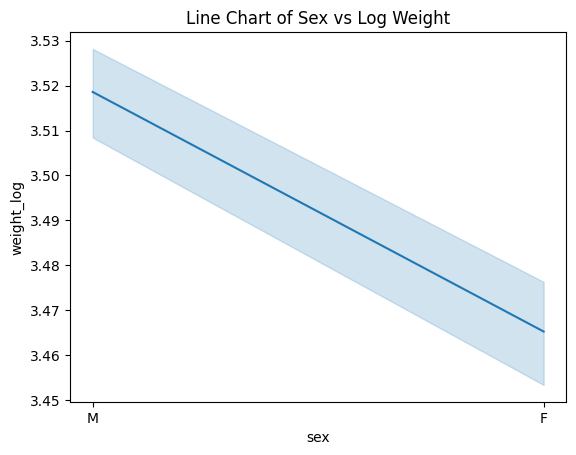

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


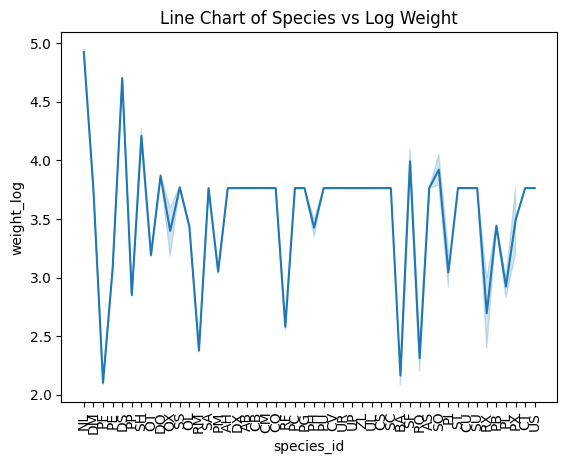

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


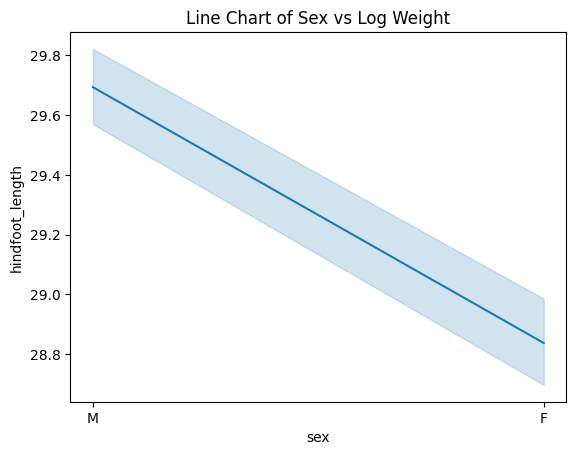

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


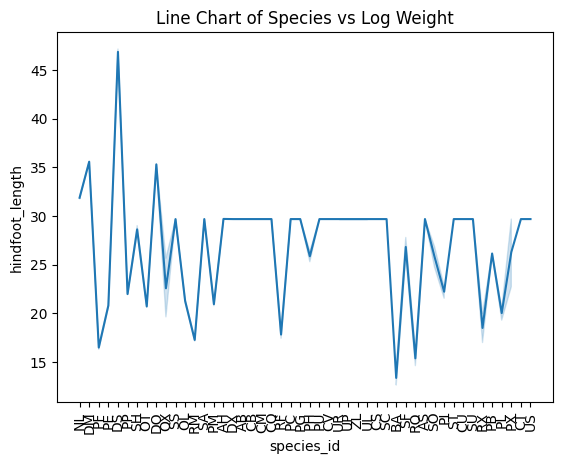

In [20]:
# we will plot some charts between numerical and categorical variables
sns.lineplot(x='sex', y='weight_log', data=df)
plt.title('Line Chart of Sex vs Log Weight')
plt.show()


sns.lineplot(x='species_id', y='weight_log', data=df)
plt.xticks(rotation=90)
plt.title('Line Chart of Species vs Log Weight')
plt.show()

sns.lineplot(x='sex', y='hindfoot_length', data=df)
plt.title('Line Chart of Sex vs Log Weight')
plt.show()


sns.lineplot(x='species_id', y='hindfoot_length', data=df)
plt.xticks(rotation=90)
plt.title('Line Chart of Species vs Log Weight')
plt.show()


In [21]:
# t-test
male_weight = df[df['sex'] == 'M']['weight_log']
female_weight = df[df['sex'] == 'F']['weight_log']

t_stat, p_val = stats.ttest_ind(male_weight, female_weight)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")

if p_val < 0.05:
    print("Conclusion: There is a significant difference in log_weight between male and female.")
else:
    print("Conclusion: There is no significant difference in log_weight between male and female.")

T-statistic: 6.870620051741744
P-value: 6.499817916173421e-12
Conclusion: There is a significant difference in log_weight between male and female.


In [22]:
# anova test
anova_result = stats.f_oneway(
    df[df['species_id'] == 'DM']['weight_log'],
    df[df['species_id'] == 'PP']['weight_log'],  
)
print(f"F-statistic: {anova_result.statistic}")
print(f"P-value: {anova_result.pvalue}")

if anova_result.pvalue < 0.05:
    print("Conclusion: There is a significant difference in weight_log between species.")
else:
    print("Conclusion: There is no significant difference in weight_log between species.")

F-statistic: 48435.040582334346
P-value: 0.0
Conclusion: There is a significant difference in weight_log between species.
